<a href="https://colab.research.google.com/github/alirezaght/bitcoin-price-prediction/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download historical data

I'm downloading btc price from https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv

and eth price from https://www.cryptodatadownload.com/cdd/Bitstamp_ETHUSD_d.csv

and gold price from https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical

and oil price from https://www.nasdaq.com/market-activity/commodities/cl:nmx/historical

In [1]:
!gdown 11IppFUtMJ6CSs4AAc_mAz8DpIrESY03H
!gdown 1Vx3NGEQNssg03QXXlIjtFDjMC_8Vm9Hr
!gdown 1Ih-kXFor9L3YSQYJPdh7XRnuqbPt34Hv
!gdown 1CucFfrWKJJGngd8PaZXv1ygnFpNnyeJl

Downloading...
From: https://drive.google.com/uc?id=11IppFUtMJ6CSs4AAc_mAz8DpIrESY03H
To: /content/gold-price.csv
100% 116k/116k [00:00<00:00, 40.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Vx3NGEQNssg03QXXlIjtFDjMC_8Vm9Hr
To: /content/btc-price.csv
100% 285k/285k [00:00<00:00, 61.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ih-kXFor9L3YSQYJPdh7XRnuqbPt34Hv
To: /content/eth-price.csv
100% 186k/186k [00:00<00:00, 19.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CucFfrWKJJGngd8PaZXv1ygnFpNnyeJl
To: /content/oil-price.csv
100% 109k/109k [00:00<00:00, 52.7MB/s]


# Preprocess *data*

In [7]:
from tensorflow.python.ops.ragged.row_partition import np
from functools import reduce 
import pandas as pd
from datetime import datetime
import math

gold_csv = pd.read_csv('gold-price.csv', keep_default_na=False)
btc_csv = pd.read_csv('btc-price.csv', keep_default_na=False)
eth_csv = pd.read_csv('eth-price.csv', keep_default_na=False)
oil_csv = pd.read_csv('oil-price.csv', keep_default_na=False)



feed_days = 90
indicators = 8

oils = {}
oils_vols = {}

for i in range(0, len(oil_csv)):  
  if oil_csv.iloc[i, 2] == "N/A":
    continue
  oil_time = datetime.strptime(oil_csv.iloc[i, 0], "%m/%d/%Y").timestamp()
  oils[oil_time] = float(oil_csv.iloc[i, 3])  
  oils_vols[oil_time] = float(oil_csv.iloc[i, 2])

original = []

index = 1
for i in range(0, len(gold_csv)):  
  if i >= len(btc_csv) or i >= len(eth_csv):
    break
  gold_time = datetime.strptime(gold_csv.iloc[i, 0], "%m/%d/%Y").timestamp()
  if gold_time not in oils:
    continue
  
  oil_price = oils[gold_time]
  oil_vol = oils_vols[gold_time]
  gold_price = float(gold_csv.iloc[i, 3]) # open price  
  if gold_csv.iloc[i, 2] == "N/A":
    continue
  gold_vol = float(gold_csv.iloc[i, 2])   
  while True: 
    if index >= len(btc_csv) or index >= len(eth_csv):
      break   
    btc_time = float(btc_csv.iloc[index].name[0])
    if btc_time < gold_time:      
      break   
    btc_price = float(btc_csv.iloc[index].name[3]) # open price        
    btc_vol = float(btc_csv.iloc[index][0]) 
    eth_price = float(eth_csv.iloc[index].name[3]) # open price    
    eth_vol = float(eth_csv.iloc[index][0]) 
    index += 1
    original.append([btc_price, btc_vol, gold_price, gold_vol, eth_price, eth_vol, oil_price, oil_vol])
original = np.array(original)


# Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(original)

x_train = []
y_train = []
for i in range(feed_days, len(data)):
  x_train.append(np.reshape(data[i - feed_days: i], (1, feed_days * indicators)))
  y_train.append(data[i][0])


x_train = np.reshape(x_train, (len(x_train), feed_days, indicators))
y_train = np.reshape(y_train, (len(y_train)))


# Build Model and Train

In [9]:
from tensorflow.keras import layers
from tensorflow import keras


model = keras.Sequential()

model.add(layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))


model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 1))

model.compile(optimizer="adam", loss="mse")
model.fit(x_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
55/55 [==============================] - 36s 406ms/step - loss: 0.0155
Epoch 2/30
55/55 [==============================] - 30s 540ms/step - loss: 0.0061
Epoch 3/30
55/55 [==============================] - 25s 447ms/step - loss: 0.0053
Epoch 4/30
55/55 [==============================] - 22s 404ms/step - loss: 0.0050
Epoch 5/30
55/55 [==============================] - 22s 404ms/step - loss: 0.0048
Epoch 6/30
55/55 [==============================] - 24s 439ms/step - loss: 0.0043
Epoch 7/30
55/55 [==============================] - 28s 508ms/step - loss: 0.0046
Epoch 8/30
55/55 [==============================] - 26s 477ms/step - loss: 0.0040
Epoch 9/30
55/55 [==============================] - 26s 463ms/step - loss: 0.0033
Epoch 10/30
55/55 [==============================] - 22s 396ms/step - loss: 0.0030
Epoch 11/30
55/55 [==============================] - 24s 430ms/step - loss: 0.0036
Epoch 12/30
55/55 [==============================] - 23s 419ms/step - loss: 0.0032
Epoch 13/30
5

# Predict

1/1 [==============================] - 0s 219ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))


1/1 [==============================] - 0s 50ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))


1/1 [==============================] - 0s 53ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

1/1 [==============================] - 0s 50ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

1/1 [==============================] - 0s 56ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

1/1 [==============================] - 0s 48ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

1/1 [==============================] - 0s 49ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

1/1 [==============================] - 0s 48ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))


1/1 [==============================] - 0s 54ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

1/1 [==============================] - 0s 63ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))


1/1 [==============================] - 0s 52ms/step


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))


1/1 [==============================] - 0s 70ms/step
End:
-0.10365326868207055
Min:
-0.10365326868207055
Max:
0.0


<ipython-input-15-aa0c0032487a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))


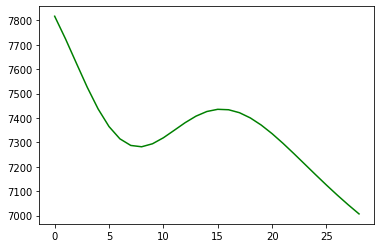

In [15]:
import matplotlib.pyplot as plt

x = np.array([])
x = np.append(x, original[len(original) - feed_days: len(original)])
x = np.reshape(x, (feed_days, indicators))
x = scaler.transform(x)
x = np.reshape(x, (1, feed_days, indicators))
res_array = np.array([])
y_array = np.array([])
for i in range(1, 30):
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0, 0, 0, 0]), (1, indicators)))
  y_array = np.append(y_array, res[0][0])
  res_array = np.append(res_array, res[0][0])
  res_array = np.append(res_array, original[len(original) - 1][1:])
  res_array = np.reshape(res_array, (i, indicators))  
  x = np.append(original[len(original) - feed_days + i: len(original)], res_array, axis = 0)    
  x = scaler.transform(x)
  x = np.reshape(x, (1, feed_days, indicators))


plt.plot(y_array, color='green')
print("End:")
print((y_array[len(y_array) - 1] - y_array[0])/y_array[0])
print("Min:")
print((min(y_array) - y_array[0])/y_array[0])
print("Max:")
print((max(y_array) - y_array[0])/y_array[0])